In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
import numpy as np
import pickle
import polars as pl
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

In [3]:
file = pl.read_csv("../../data/preprocessedData.csv")
file.head(3)

temp,feelsLike,pressure,humidity,clouds,windSpeed,windDir,gustSpeed,result
f64,f64,f64,f64,f64,f64,f64,f64,i64
35.6,36.9,978.0,35.0,100.0,3.05,220.0,4.0,1
34.4,35.3,979.0,37.0,100.0,0.78,144.0,2.0,1
33.3,34.8,981.0,42.0,100.0,2.02,78.0,2.02,1


In [4]:
x = file.drop('result')
y = file['result']

In [5]:
x_train, x_test ,y_train ,y_test = train_test_split(x,y,test_size=0.3,random_state=99)

In [6]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [7]:
randomForestClassifier = RandomForestClassifier(n_estimators=99, random_state=99)
randomForestClassifier.fit(x_train, y_train)

RandomForestClassifier(n_estimators=99, random_state=99)

In [8]:
x_test

array([[-0.29762375, -0.26996059,  0.08060794, ...,  0.2304302 ,
         0.24420818, -0.21076516],
       [ 0.78918553,  1.46235135, -0.24303505, ..., -1.14953837,
        -1.90674825, -0.21076516],
       [ 0.3779604 ,  0.33057422, -0.24303505, ...,  0.75226706,
        -0.22394116,  0.48096415],
       ...,
       [-0.12138441,  0.23818425,  1.77973366, ...,  2.88020179,
         0.13033402,  2.21028744],
       [-0.76759533, -0.87049539,  0.16151869, ..., -0.94660181,
        -0.38842606, -1.19647943],
       [-0.00389151,  0.14579428, -1.29487478, ...,  1.34368216,
         0.21890281,  0.34261829]])

In [9]:
predict = randomForestClassifier.predict(x_test)

column_dict = {
  "original": y_test, 
  "predicted": predict
}

prediction_csv = pl.DataFrame(column_dict)

prediction_csv.write_csv("prediction_result.csv")

In [10]:
accuracy = accuracy_score(predict, y_test)
confusion_matrix = confusion_matrix(predict, y_test)

print(f'Accuracy_score: {accuracy}')
print(f'\nConfusion Matrix: \n {confusion_matrix}')

Accuracy_score: 0.8922155688622755

Confusion Matrix: 
 [[617  86]
 [ 58 575]]


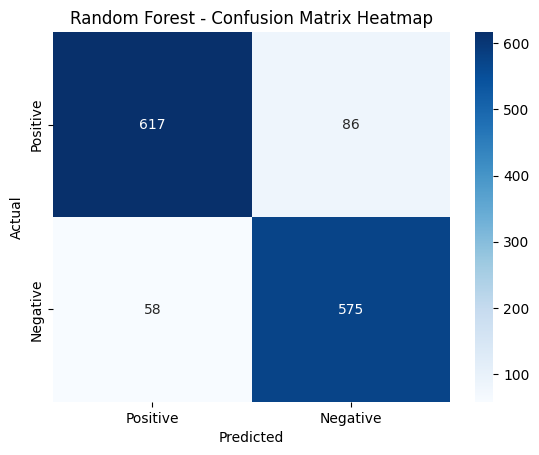

In [15]:
labels = ['Positive', 'Negative']
confusion_df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix Heatmap")
plt.savefig("./report_images/confusion_matrix_heatmap.png")
plt.show()

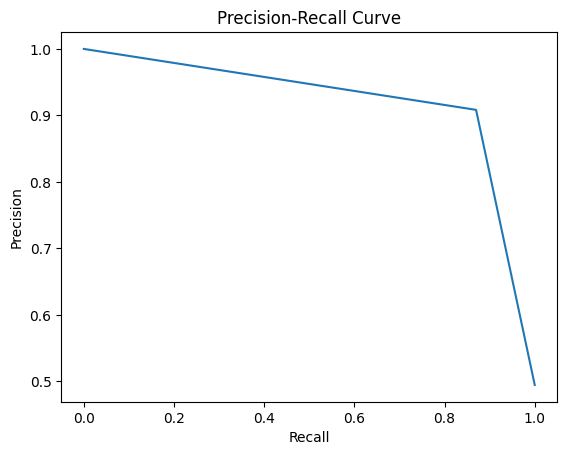

In [13]:
# **Precision-Recall Curve**: This plot is useful in imbalanced datasets to understand the trade-off between precision and recall for different threshold.

precision, recall, _ = precision_recall_curve(y_test, predict)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig("./report_images/precision_recall_curve.png")
plt.show()

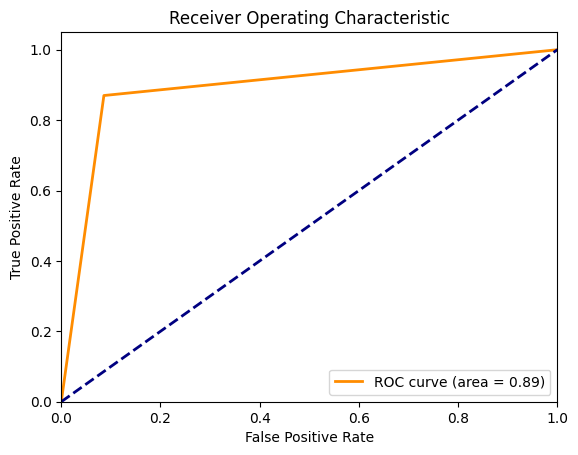

In [14]:
# **ROC Curve**: It's a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.
fpr, tpr, _ = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("./report_images/roc_curve.png")
plt.show()

In [11]:
for i in range(0, 99):
  estimator = randomForestClassifier.estimators_[i]
  tree_rules = export_text(estimator, feature_names=list(x.columns))
  with open("trueRules.txt", 'a') as file:
    file.write(f"Tree {i+1} Rules: /n/n")
    file.write(tree_rules + "/n/n/n")

In [12]:
with open("model.pickle", 'wb') as file:
  pickle.dump(randomForestClassifier, file)